In [8]:
import os
from tensorflow.python.keras.preprocessing import image
import cv2
from multiclassunet import Unet
import tqdm
import os
import random
import time
import numpy as np
import json
from moviepy.editor import VideoFileClip, ImageSequenceClip

In [2]:
h, w = 256, 256
with open('config.json', 'r') as f:
    config = json.load(f)
labels = config['labels']
color_map = {}
for label in labels:
    color_map[label['readable']] = label['color']
label_list = sorted(color_map.keys())
id_to_color = {v:color_map[k] for v,k in enumerate(label_list)}
id_to_label = {v:k for v,k in enumerate(label_list)}

In [3]:
unet = Unet(h, w, 66)
unet.load_weights('unet_new.h5')

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`


In [4]:
def pipeline(image, video=True, return_seg=False, to_outline=True):
    alpha = 0.65
    dims = image.shape
    x = cv2.resize(image, (w, h))
    x = np.float32(x)/255.
    z = unet.predict(np.expand_dims(x, axis=0))
    z = np.squeeze(z)
    z = cv2.resize(z, (dims[1], dims[0]))
    y = np.argmax(z, axis=2)
    
    img_color = image.copy()   
    for i in np.unique(y):
        img_color[y==i] = id_to_color[i]
    if video:
        if to_outline:
            return segmap_to_outline(img_color)
        cv2.addWeighted(image, alpha, img_color, 1-alpha, 0, img_color)        
        return img_color
    if return_seg:
        return img_color/255.
    else:
        cv2.addWeighted(image, alpha, img_color, 1-alpha, 0, img_color)        
        plt.figure(figsize=(15, 10))
        plt.imshow(img_color/255.0)
#     cv2.imwrite(f'outputs/{np.random.randint(0,5000)}.png',  cv2.cvtColor(img_color, cv2.COLOR_RGB2BGR))


def segmap_to_outline(segmap):
    img_height, img_width = segmap.shape[0], segmap.shape[1]
    segmap = cv2.cvtColor(segmap, cv2.COLOR_BGR2GRAY)
    outline = np.full_like(segmap, 255.)
    for i in range(2,img_height-2):
        for j in range(2,img_width-2):
            pixel = segmap[i, j]
            top = segmap[i+2,j]
            bottom = segmap[i-2,j]
            left = segmap[i,j-2]
            right = segmap[i,j+2]
            top_right = segmap[i+2,j+2]
            top_left = segmap[i+2,j-2]
            bottom_right = segmap[i-2,j+2]
            bottom_left = segmap[i-2,j-2]
            if len(set([pixel, top, bottom, left, right, top_right, top_left, bottom_right, bottom_left])) != 1:
                outline[i, j] = 0
    return np.stack([outline]*3, axis=-1)

In [ ]:
clip = VideoFileClip('../scene-parsing/karol.mp4', target_resolution=(360, 640))
res = clip.fl_image(pipeline)
res.write_videofile('karol_outline.mp4', audio=False)

[MoviePy] >>>> Building video karol_outline.mp4
[MoviePy] Writing video karol_outline.mp4


  1%|▏         | 685/45912 [04:05<4:30:41,  2.78it/s]

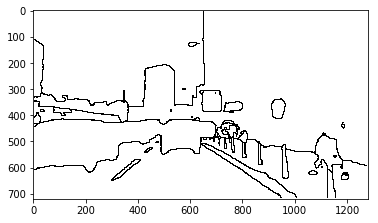

In [51]:
plt.imshow(pipeline(clip.get_frame(22)))

In [3]:
test_dir = 'validate'
image_list = os.listdir(test_dir)
print(f'{len(image_list)} frames found')

1100 frames found


In [ ]:
i = 1
test = image.load_img(f'{test_dir}/{image_list[i]}')
test = image.img_to_array(test)
segmap = pipeline(test, video=False, return_seg=True)
plt.imshow(segmap)